### Multi-head Attention Matrices


$$ Q\cdot K^T = X\,(W_Q \cdot W_K^T)\,X^T$$
Here we search for a possible mathematical interpretation of the linear transformations involved in the computation of $Q, K, V$ in multi-head attention. Specifically, we want to answer the following questions:


In single head attention:

- how different is the matrix $W_Q \cdot W_K^T$ from the identity matrix? If we find a significative difference, it means that the attention is doing something more than $X\cdot X^T$ - i.e. the projection of the buffer on itself;

- is $W_Q \cdot W_K^T$ symmetric? In that case, the attention weights can be seen as $X' \cdot X'^T$ where $X' = A\cdot X$.

**NOTES** Which model should we choose?

- GPT2Model: the base transformer, outputs the hidden states(the embedded buffer, X, after all the transformations)
- GPT2LMHeadModel: the base transformer, plus the layer which calculates the probabilities (aka the token logits) $p(t_i) \propto exp(\vec{x}_N\cdot \vec{x}_{t_i})$ for each token $t_i$ in the vocabulary.
- GPT2DoubleHeadsModel: has both the layer that calculates the probabilities and a layer for classification (whatever it is). Used for multiple-choice Q&A.


We need to use GPT2LMHeadModel.from_pretrained(). This is an instance of the class `transformers.PreTrainedModel` and inherits all its methods. Check its the documentation.


Also check `transformers.GenerationMixin.generate()` and its documentation.

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import numpy as np

# Load pretrained model
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
inputs =  tokenizer(["Today we can go to"], return_tensors="pt") # atributes: input_ids, attention_mask
print(inputs.input_ids)
outputs = model.generate(**inputs, max_new_tokens = 1,
                        return_dict_in_generate = True,
                        output_scores = True,
                        temperature = 1.0,
                        output_logits = True,
                        output_hidden_states = True,
                        output_attentions = True,
                        pad_token_id = 50256)

type(outputs) # transformers.generation.utils.GenerateDecoderOnlyOutput

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


tensor([[8888,  356,  460,  467,  284]])


transformers.generation.utils.GenerateDecoderOnlyOutput

Documentation [here](https://huggingface.co/docs/transformers/v4.51.3/en/internal/generation_utils#transformers.generation.GenerateDecoderOnlyOutput)

**Notes**
Scores are equal to logits in case of greedy decoding, but are different in case of more fancy decoding methods like `beam`, or `top_k`. See the 
doc page [Generation Strategies](https://huggingface.co/docs/transformers/en/generation_strategies#decoding-strategies). See [here](https://discuss.huggingface.co/t/what-is-the-difference-between-logits-and-scores/79796/3) for forum discussion.



logits (tuple(torch.FloatTensor) optional, returned when output_logits=True) — Unprocessed prediction scores of the language modeling head (scores for each vocabulary token before SoftMax) at each generation step. Tuple of torch.FloatTensor with up to max_new_tokens elements (one element for each generated token), with each tensor of shape (batch_size, config.vocab_size).

attentions (tuple(tuple(torch.FloatTensor)), optional, returned when output_attentions=True) — Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of torch.FloatTensor of shape (batch_size, num_heads, generated_length, sequence_length).

hidden_states (tuple(tuple(torch.FloatTensor)), optional, returned when output_hidden_states=True) — Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of torch.FloatTensor of shape (batch_size, generated_length, hidden_size).

### Logits

In [2]:
print(outputs.sequences.shape)
print(tokenizer.decode(outputs.sequences[0][0], skip_special_tokens =False))
print(tokenizer.decode(outputs.sequences[0][:], skip_special_tokens =False))

torch.Size([1, 6])
Today
Today we can go to the


In [3]:
logits = outputs.scores[0][0]
top_values, top_indices = torch.topk(logits, k=10, largest=True)  # or largest=False for smallest
for idx, val in zip(top_indices.tolist(), top_values.tolist()):
    print(f"Index: {idx}, Value: {val}, Decoded: {tokenizer.decode(idx)}")

Index: 262, Value: -80.64991760253906, Decoded:  the
Index: 257, Value: -81.82210540771484, Decoded:  a
Index: 670, Value: -82.49638366699219, Decoded:  work
Index: 1175, Value: -82.70538330078125, Decoded:  war
Index: 597, Value: -82.73980712890625, Decoded:  any
Index: 3993, Value: -82.82905578613281, Decoded:  sleep
Index: 674, Value: -83.12396240234375, Decoded:  our
Index: 1194, Value: -83.35417175292969, Decoded:  another
Index: 3996, Value: -83.4070816040039, Decoded:  bed
Index: 477, Value: -83.7303237915039, Decoded:  all


### Hidden states at the end of each layer

We can follow the buffer as it exits each of the layers. Hidden-states of the model at the output of each layer plus the optional initial embedding outputs. In this case, $1 + 12 = 13$.

In [91]:
print(len(outputs.hidden_states[0]))

13


In [ ]:
print(outputs.hidden_states[0][0][0].shape) # hidden_states[generated token number][layer number] is a tensor (input length x D)

torch.Size([5, 768])


# Accessing model parameters

Now we retrieve the set of model parameters that are all learned during the training, and kept fixed during inference. These includes:

- the embedding map, E
- the attention matrices, in each layer and each head $(W_Q, W_K, W_V)$ 
- the neural net weights, in each layer


When instanciating the model using "from_pretrained()", dropout is deactivated by default by  model.eval() (sets the model to evaluation mode). To train the model, you should first set it back in training mode with model.train().

In [2]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [99]:
# dir(model) # check all methods and attributes of the class

In [6]:
state_dict = model.state_dict()
for name, weights in state_dict.items():
    print(name, weights.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [7]:
embedding_matrix = state_dict["transformer.wte.weight"] # E
lm_head_matrix = state_dict["lm_head.weight"]
torch.equal(embedding_matrix, lm_head_matrix) # True

True

**SOURCE CODE** [HERE](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py)

### Attention matrices


1 - Transformation to queries, keys, values. Matrices are stacked together horizontally (column- wise). This way, only 1 matrix multiplication is required instead of 3.
$$
\begin{align}
    [Q, K, V] &= X \cdot [W_Q, W_K, W_V] + 
    \begin{pmatrix}
        \text{bias QKV} \\
        \cdots \\
        \text{bias QKV}
    \end{pmatrix} \\
    (N \cdot 3D) &= (N \cdot D) \cdot (D \cdot 3D) + (N \cdot 3D)
\end{align}
$$
2 - Splitting into heads:

$ \begin{align}
    Q &\rightarrow [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  \\
\end{align}
$

3 - Attention computation:
$ \begin{align}
    \text{head h} &= \text{softmax}\left( \frac{Q_h\cdot K_h^T}{\sqrt{d_K} } \right) [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  
\end{align}
$

4 - Backwards projection

$
\begin{align}
Y &= [\text{head 1},\, \text{head 2} \cdots \text{head nH}] \cdot W_0 + 
    \begin{pmatrix}
        \text{bias 0 } \\
        \cdots \\
        \text{bias 0}
    \end{pmatrix} \\
    (N\cdot D) &= (N \cdot D) \cdot (D\cdot D) + (N \cdot D) \\
\end{align}
$

In [8]:
layer_max = 12
qkv_weights = [state_dict[f"transformer.h.{i}.attn.c_attn.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of N x (3D) matrices
qkv_biases = [state_dict[f"transformer.h.{i}.attn.c_attn.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
projection_weights = [state_dict[f"transformer.h.{i}.attn.c_proj.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x D matrices
projection_biases = [state_dict[f"transformer.h.{i}.attn.c_proj.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
print(qkv_weights[0].shape)
print(qkv_biases[0].shape)
print(projection_weights[0].shape)
print(projection_biases[0].shape)

(768, 2304)
(2304,)
(768, 768)
(768,)


In [9]:
D = 768
q_weights = [qkv_weights[i][:,0:D] for i in range(0, layer_max)]
k_weights = [qkv_weights[i][:,D:(2*D)] for i in range(0, layer_max)]
qkt_weights = [np.matmul(q_weights[i], k_weights[i].T) for i in range(0, layer_max)]

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_8185/835126048.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


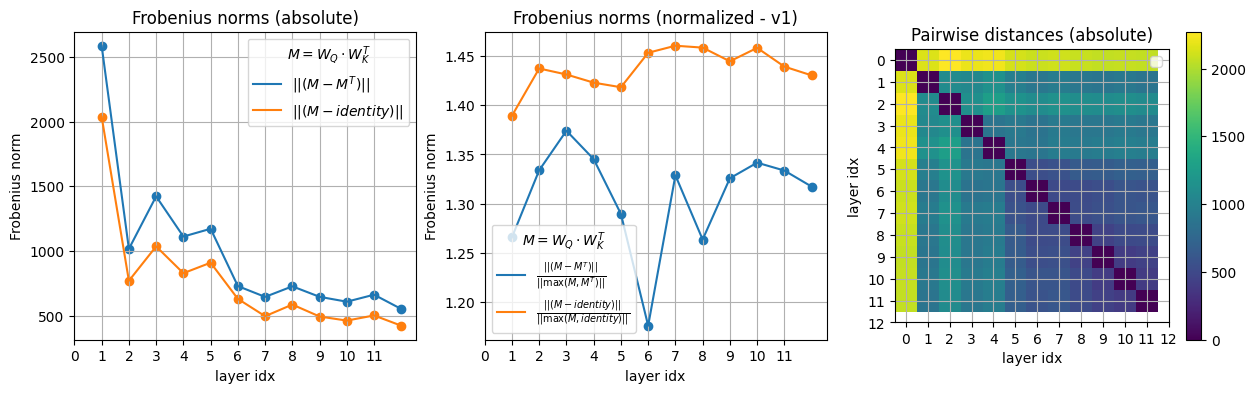

In [11]:
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Symmetric?  Distance of QKt - (QKt)t from the null matrix
distances_symm = [norm(qkt_weights[i] - qkt_weights[i].T, ord = "fro") for i in range(0, layer_max)]
# normalization -v1
maximum_symmetric_norms = [norm(np.maximum(qkt_weights[i], qkt_weights[i].T), ord = "fro") for i in range(layer_max)]
distances_symm_normalized = [distances_symm[i]/maximum_symmetric_norms[i] for i in range(0, layer_max)]



# Difference from the identiy matrix ?
maximum_identity_norms = [norm(np.maximum(qkt_weights[i], np.eye(D)), ord = "fro") for i in range(layer_max)]
distances_identity = [norm(qkt_weights[i] - np.eye(D), ord = "fro") for i in range(0, layer_max)]
distances_identity_normalized = [distances_identity[i]/maximum_identity_norms[i] for i in range(0, layer_max)]


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
plt.subplots_adjust(hspace = 0.3)


axs[0].plot(np.arange(1, layer_max + 1), distances_symm, label = r"$||(M - M^T)||$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_symm)
axs[0].plot(np.arange(1, layer_max + 1), distances_identity, label = r"$||(M - identity)||$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_identity)
axs[0].grid()
axs[0].set_title("Frobenius norms (absolute)")
axs[0].set_xlabel("layer idx")
axs[0].set_ylabel("Frobenius norm")
axs[0].set_xticks(np.arange(0, 12))
axs[0].legend(title = r"$M = W_Q\cdot W_K^T$")

axs[1].plot(np.arange(1, layer_max + 1), distances_symm_normalized, label = r"$\frac{||(M - M^T)||}{||\text{max}(M, M^T)||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_symm_normalized)
axs[1].plot(np.arange(1, layer_max + 1), distances_identity_normalized, label = r"$\frac{||(M - identity)||}{||\text{max}(M, identity)||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_identity_normalized)
axs[1].grid()
axs[1].set_title("Frobenius norms (normalized - v1)")
axs[1].set_xlabel("layer idx")
axs[1].set_ylabel("Frobenius norm")
axs[1].set_xticks(np.arange(0, 12))
axs[1].legend(title = r"$M = W_Q\cdot W_K^T$")


distances_pairwise = [[norm(qkt_weights[i] - qkt_weights[j]) for j in range(0, layer_max)] for i in range(0, layer_max)]


im = axs[2].imshow(distances_pairwise)
fig.colorbar(im, ax=axs[2])
axs[2].grid()
axs[2].set_title("Pairwise distances (absolute)")
axs[2].set_xticks(np.arange(0, 13))
axs[2].set_yticks(np.arange(0, 13))
axs[2].set_xlabel("layer idx")
axs[2].set_ylabel("layer idx")
axs[2].legend()

### Checking other normalizations

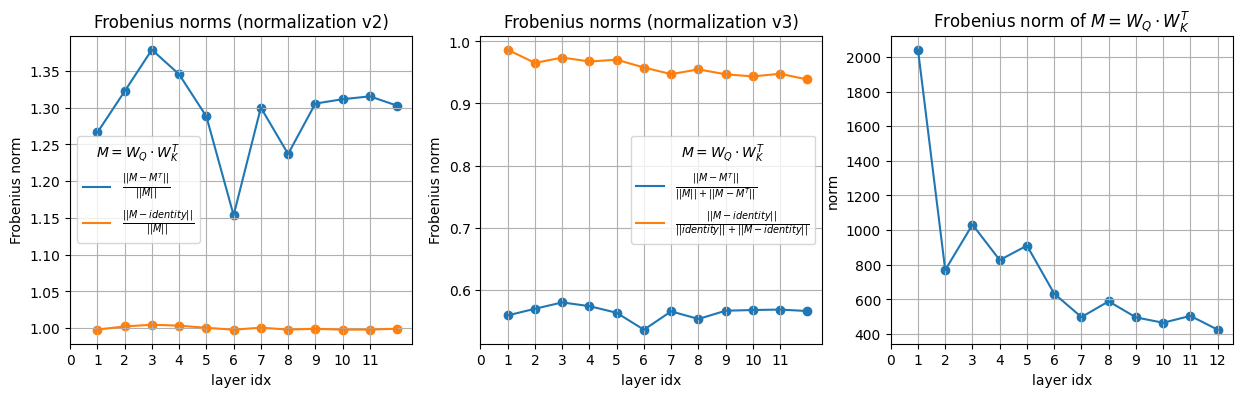

In [16]:
# normalization -v2
distances_symm_normalized_2 = [distances_symm[i]/norm(qkt_weights[i]) for i in range(0, layer_max)]
distances_identity_normalized_2 = [distances_identity[i]/norm(qkt_weights[i]) for i in range(0, layer_max)]

# normalization -v3 ()
distances_symm_normalized_3 = [distances_symm[i]/(norm(qkt_weights[i]) + distances_symm[i]) for i in range(0, layer_max)]
distances_identity_normalized_3 = [distances_identity[i]/(norm(np.eye(D)) + distances_identity[i]) for i in range(0, layer_max)]

# norm of M itself
M_norm = [norm(qkt_weights[i]) for i in range(0, layer_max)]


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
plt.subplots_adjust(hspace = 0.3)


axs[0].plot(np.arange(1, layer_max + 1), distances_symm_normalized_2, label = r"$\frac{||M- M^T||}{||M||}$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_symm_normalized_2)
axs[0].plot(np.arange(1, layer_max + 1), distances_identity_normalized_2, label = r"$\frac{||M- identity||}{||M||}$")
axs[0].scatter(np.arange(1, layer_max + 1), distances_identity_normalized_2)
axs[0].grid()
axs[0].set_title("Frobenius norms (normalization v2)")
axs[0].set_xlabel("layer idx")
axs[0].set_ylabel("Frobenius norm")
axs[0].set_xticks(np.arange(0, 12))
axs[0].legend(title = r"$M = W_Q\cdot W_K^T$")



axs[1].plot(np.arange(1, layer_max + 1), distances_symm_normalized_3, label = r"$\frac{||M- M^T||}{||M|| + ||M - M^T||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_symm_normalized_3)
axs[1].plot(np.arange(1, layer_max + 1), distances_identity_normalized_3, label = r"$\frac{||M- identity||}{||identity|| + ||M - identity||}$")
axs[1].scatter(np.arange(1, layer_max + 1), distances_identity_normalized_3)
axs[1].grid()
axs[1].set_title("Frobenius norms (normalization v3)")
axs[1].set_xlabel("layer idx")
axs[1].set_ylabel("Frobenius norm")
axs[1].set_xticks(np.arange(0, 12))
axs[1].legend(title = r"$M = W_Q\cdot W_K^T$")


axs[2].plot(np.arange(1, layer_max + 1), M_norm)
axs[2].scatter(np.arange(1, layer_max + 1), M_norm)
axs[2].set_xlabel("layer idx")
axs[2].set_ylabel("norm")
axs[2].set_title(r"Frobenius norm of $M = W_Q\cdot W_K^T$")
axs[2].set_xticks(np.arange(0, 13))
axs[2].grid()